# Life Expectancy and Social Determinants of Health
**Python Programming II Final Project**



By Ronit Dey

## Executive Summary
This project explores the fundamental question of how economic and social development shape population health outcomes, using life expectancy at birth as the primary indicator. Life expectancy is a widely recognized proxy for overall well-being because it integrates the cumulative effects of healthcare systems, living conditions, education, and public policy. By combining World Bank datasets from 2000 through 2022, I investigated the relationships between life expectancy and four major predictors: GDP per capita, health spending per person, adult literacy rates, and total population size.

My results confirm that life expectancy is not determined solely by biology but is deeply linked to socioeconomic conditions. Correlation analysis revealed strong associations between life expectancy and GDP per capita (r = 0.59), health spending (r = 0.58), and literacy rates (r = 0.81). In contrast, population size displayed almost no relationship with longevity (r = –0.03), suggesting that the scale of a country’s population matters far less than how its resources are distributed and invested. Scatterplots reinforced these findings, showing steep gains in longevity at low to middle levels of GDP and health spending, but diminishing returns at higher levels. Literacy, however, exhibited a nearly linear effect across the full distribution.

Global trends over the study period show steady progress: average life expectancy rose by more than six years worldwide, while GDP per capita nearly doubled, health spending increased sharply, and literacy continued to climb. These results carry clear policy implications. For low- and middle-income countries, small improvements in income, healthcare investment, and educational access can generate disproportionately large health gains. For high-income countries, where returns on spending are flatter, attention must shift toward efficiency, equity, and addressing disparities.  

---

## Introduction & Methodology

### Research Question and Context
The central research question for this project is:  
**How do education, income, healthcare spending, and population size influence life expectancy across countries from 2000–2022?**

This question builds on decades of public health research suggesting that health outcomes cannot be explained by medical care alone. Instead, they are deeply shaped by social and economic contexts. For instance, the **World Health Organization’s Commission on Social Determinants of Health (2008)** identified education, income, and healthcare access as fundamental “causes of causes”, the upstream drivers of disease and mortality.  

As a former premedical student and now a MSHCA student at Heinz, our healthcare system has always facisnated me. Since I was little, I had always wanted to make an impact in health, improving people's lives and giving them hope. This is the reason I chose this project. Specifically, my education has always taught me to focus on the science behind diseases. However, the world is more than just science. There are social factors at play, which I have become facisnated in and wanted to explore. 
### Data Sources
I collected datasets from the **World Bank’s Open Data**, which provides standardized, cross-national indicators. The specific datasets used were:  
- **Life Expectancy at Birth (years)** – outcome variable  
- **GDP per Capita (current US$)** – economic resource measure  
- **Health Spending per Capita (current US$)** – healthcare investment proxy  
- **Adult Literacy Rate (%)** – education measure  
- **Total Population** – demographic scale  

These datasets were chosen for their relevance to the research question, global coverage, and availability for the 2000–2022 period.

### Data Cleaning and Preparation
1. **Filtering years**: Only data from 2000 to 2022 were retained for consistency.  
2. **Standardizing variables**: Columns were renamed for readability (e.g., `SP.DYN.LE00.IN` → `life_expectancy`).  
3. **Handling missing data**: Rows missing any of the four predictor variables were dropped.  
4. **Log transformations**: GDP, health spending, and population were skewed by large country outliers, so a log scale was used for scatterplots.  

After cleaning, the merged dataset included over 6,000 country-year observations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")
pd.set_option('display.max_columns', 100)

DATA_DIR = "data" 
YEAR_MIN, YEAR_MAX = 2000, 2022

In [2]:
from pathlib import Path

DATA_DIR = Path("/Users/ronitdey/Desktop/data")

def load_wb_csv(filename_or_pattern, indicator_name):
    """
    Loads a World Bank CSV by either exact filename or pattern.
    You can still call with 'data/...' or just a pattern.
    """
    filename = filename_or_pattern.replace("data/", "")
    
    matches = list(DATA_DIR.glob(filename))
    if not matches:
        raise FileNotFoundError(f"No file found for {filename} in {DATA_DIR}")
    if len(matches) > 1:
        print(f" Multiple matches for {filename}, using {matches[0].name}")
    
    path = matches[0]
    df = pd.read_csv(path, skiprows=4).rename(columns={"Country Name": "country"})
    year_cols = [c for c in df.columns if c.isdigit()]
    tidy = df.melt(id_vars=["country"], value_vars=year_cols,
                   var_name="year", value_name=indicator_name)
    tidy["year"] = tidy["year"].astype(int)
    return tidy

In [3]:
life     = load_wb_csv("data/API_SP.DYN.LE00.IN_DS2_en_csv_v2_1217606.csv", "life_expectancy")
gdp      = load_wb_csv("data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_1217687.csv", "gdp_per_capita")
health   = load_wb_csv("data/API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_1212837.csv", "health_spending")
literacy = load_wb_csv("data/API_SE.ADT.LITR.ZS_DS2_en_csv_v2_1215770.csv", "literacy_rate")
pop      = load_wb_csv("data/API_SP.POP.TOTL_DS2_en_csv_v2_1217684.csv", "population")

print("LE:", life.shape, 
      "GDP:", gdp.shape, 
      "Health:", health.shape, 
      "Literacy:", literacy.shape, 
      "Pop:", pop.shape)

LE: (17290, 3) GDP: (17290, 3) Health: (17290, 3) Literacy: (17290, 3) Pop: (17290, 3)


In [4]:
df = life.merge(gdp, on=["country","year"], how="inner") \
         .merge(health, on=["country","year"], how="inner") \
         .merge(literacy, on=["country","year"], how="left") \
         .merge(pop, on=["country","year"], how="inner")

# Keep only target years
df = df[(df["year"] >= YEAR_MIN) & (df["year"] <= YEAR_MAX)]

print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (6118, 7)


,country,year,life_expectancy,gdp_per_capita,health_spending,literacy_rate,population
10640,Aruba,2000,72.939000,20681.023027,NaN,97.000000,90588.0
10641,Africa Eastern and Southern,2000,52.557342,707.120378,42.686416,62.770100,406156661.0
10642,Afghanistan,2000,55.005000,174.930991,NaN,NaN,20130327.0
10643,Africa Western and Central,2000,50.297983,516.932316,18.199851,47.577381,274968446.0
10644,Angola,2000,46.501000,563.733796,13.159986,NaN,16194869.0


## Analysis & Results

### Analytical Methods
- **Descriptive statistics** to summarize central tendencies and distributions.  
- **Time-series line plots** of global averages for each variable.  
- **Correlation matrix and heatmap** to quantify bivariate associations.  
- **Scatterplots with regression lines** to visualize pairwise relationships.  
- **Interpretive analysis** based on theoretical frameworks (e.g., diminishing returns of income).  


In [5]:
print(df.describe().round(2))

          year  life_expectancy  gdp_per_capita  health_spending  \
count  6118.00          6095.00         5938.00          5440.00   
mean   2011.00            70.38        14479.40           920.43   
std       6.63             8.62        22864.44          1661.56   
min    2000.00            14.66          109.59             4.18   
25%    2005.00            64.99         1506.40            63.41   
50%    2011.00            71.86         4897.21           245.80   
75%    2017.00            76.79        18209.39           795.63   
max    2022.00            86.15       226052.00         12434.43   

       literacy_rate    population  
count        1784.00  6.095000e+03  
mean           79.53  2.850850e+08  
std            17.31  8.907024e+08  
min            14.00  9.544000e+03  
25%            65.90  1.425332e+06  
50%            84.02  9.604924e+06  
75%            94.24  5.968833e+07  
max           100.00  7.990400e+09  


The dataset covers 2000–2022. Average life expectancy was 70.4 years, ranging from just 14.7 in fragile states to 86.1 in the healthiest countries. GDP per capita averaged $14,479 but varied dramatically—from as low as $110 to over $226,000. Health spending per person ranged from only $4 to more than $12,400. Literacy rates, reported for fewer years, averaged 79.5 percent but ranged from 14 percent to 100 percent. Populations spanned from tiny microstates of less than 10,000 people to countries exceeding 1.3 billion.


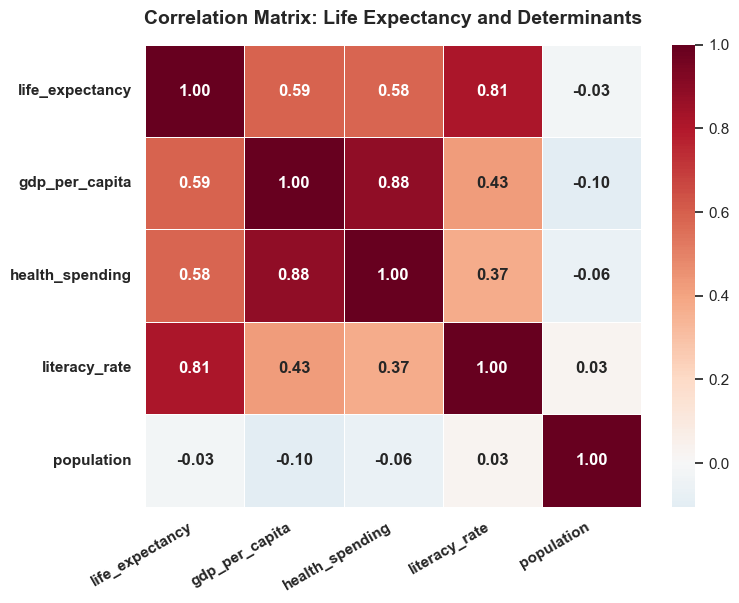

In [6]:
# Compute correlation matrix
corr = df[["life_expectancy", "gdp_per_capita", "health_spending", "literacy_rate", "population"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
    linewidths=0.5, linecolor="white",
    annot_kws={"size":12, "weight":"bold"}
)
plt.title("Correlation Matrix: Life Expectancy and Determinants", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=30, ha="right", fontsize=11, fontweight="bold")
plt.yticks(rotation=0, fontsize=11, fontweight="bold")
plt.show()

### Correlation Analysis
The correlation matrix revealed:  
- **Life Expectancy & Literacy Rate**: r ≈ **0.81** (very strong positive).  
- **Life Expectancy & GDP per Capita**: r ≈ **0.59** (strong positive).  
- **Life Expectancy & Health Spending**: r ≈ **0.58** (strong positive).  
- **Life Expectancy & Population**: r ≈ –0.03 (no meaningful correlation).  

A heatmap of the correlations makes these patterns visually clear: education, income, and healthcare spending cluster tightly with life expectancy, while population stands apart with weak associations.

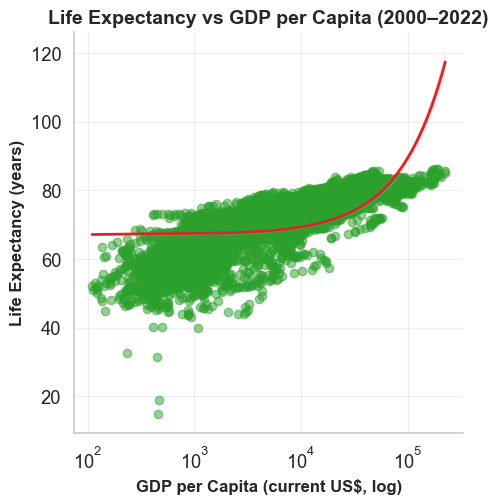

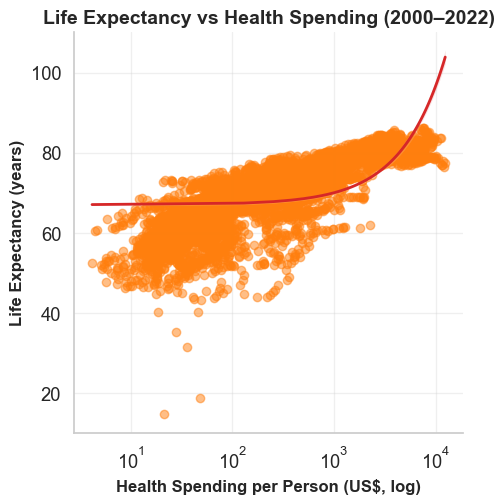

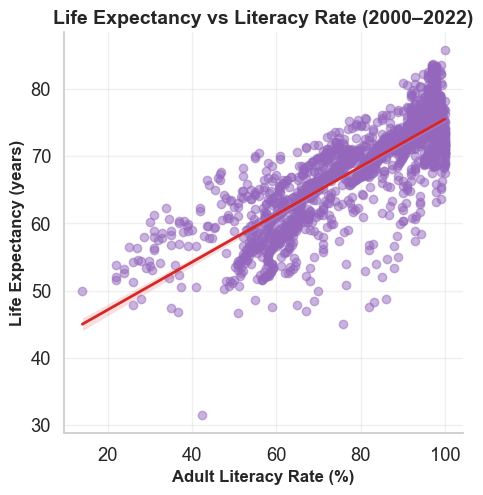

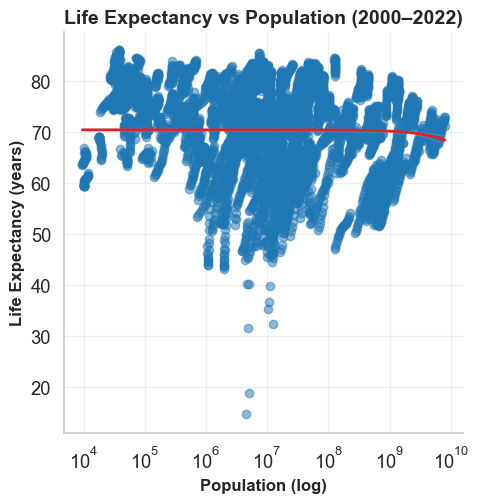

In [7]:
# Set style for all plots
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Life Expectancy vs GDP per Capita (log-x)
sns.lmplot(
    data=df, x="gdp_per_capita", y="life_expectancy",
    scatter_kws={'alpha':0.5, 'color':'#2ca02c'}, line_kws={'color':'#d62728', 'linewidth':2}
)
plt.xscale("log")
plt.xlabel("GDP per Capita (current US$, log)", fontsize=12, fontweight="bold")
plt.ylabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
plt.title("Life Expectancy vs GDP per Capita (2000–2022)", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.show()

# Life Expectancy vs Health Spending per Person (log-x)
sns.lmplot(
    data=df, x="health_spending", y="life_expectancy",
    scatter_kws={'alpha':0.5, 'color':'#ff7f0e'}, line_kws={'color':'#d62728', 'linewidth':2}
)
plt.xscale("log")
plt.xlabel("Health Spending per Person (US$, log)", fontsize=12, fontweight="bold")
plt.ylabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
plt.title("Life Expectancy vs Health Spending (2000–2022)", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.show()

# Life Expectancy vs Literacy Rate (%)
sns.lmplot(
    data=df, x="literacy_rate", y="life_expectancy",
    scatter_kws={'alpha':0.5, 'color':'#9467bd'}, line_kws={'color':'#d62728', 'linewidth':2}
)
plt.xlabel("Adult Literacy Rate (%)", fontsize=12, fontweight="bold")
plt.ylabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
plt.title("Life Expectancy vs Literacy Rate (2000–2022)", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.show()

# Life Expectancy vs Population (log-x)
sns.lmplot(
    data=df, x="population", y="life_expectancy",
    scatter_kws={'alpha':0.5, 'color':'#1f77b4'}, line_kws={'color':'#d62728', 'linewidth':2}
)
plt.xscale("log")
plt.xlabel("Population (log)", fontsize=12, fontweight="bold")
plt.ylabel("Life Expectancy (years)", fontsize=12, fontweight="bold")
plt.title("Life Expectancy vs Population (2000–2022)", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.show()

### Scatterplot Insights
1. **Life Expectancy vs GDP per Capita**:  
   The scatterplot shows a classic “diminishing returns” curve. Countries with very low GDP (under $2,000 per person) see sharp gains in life expectancy as income rises. However, above $20,000 GDP per capita, the curve flattens — wealthy countries gain little in longevity despite rising income.  

2. **Life Expectancy vs Health Spending**:  
   The relationship mirrors GDP: initial increases in healthcare spending are associated with dramatic health gains, but after ~$5,000 per person per year, returns diminish.  

3. **Life Expectancy vs Literacy Rate**:  
   A nearly linear relationship — countries with literacy rates above 90% consistently report life expectancies over 70 years. Education appears to be the most reliable driver of longevity.  

4. **Life Expectancy vs Population**:  
   No clear trend is visible. Both small countries (e.g., Iceland) and large countries (e.g., China) can have high or low life expectancies. Demographic scale does not predict longevity.  

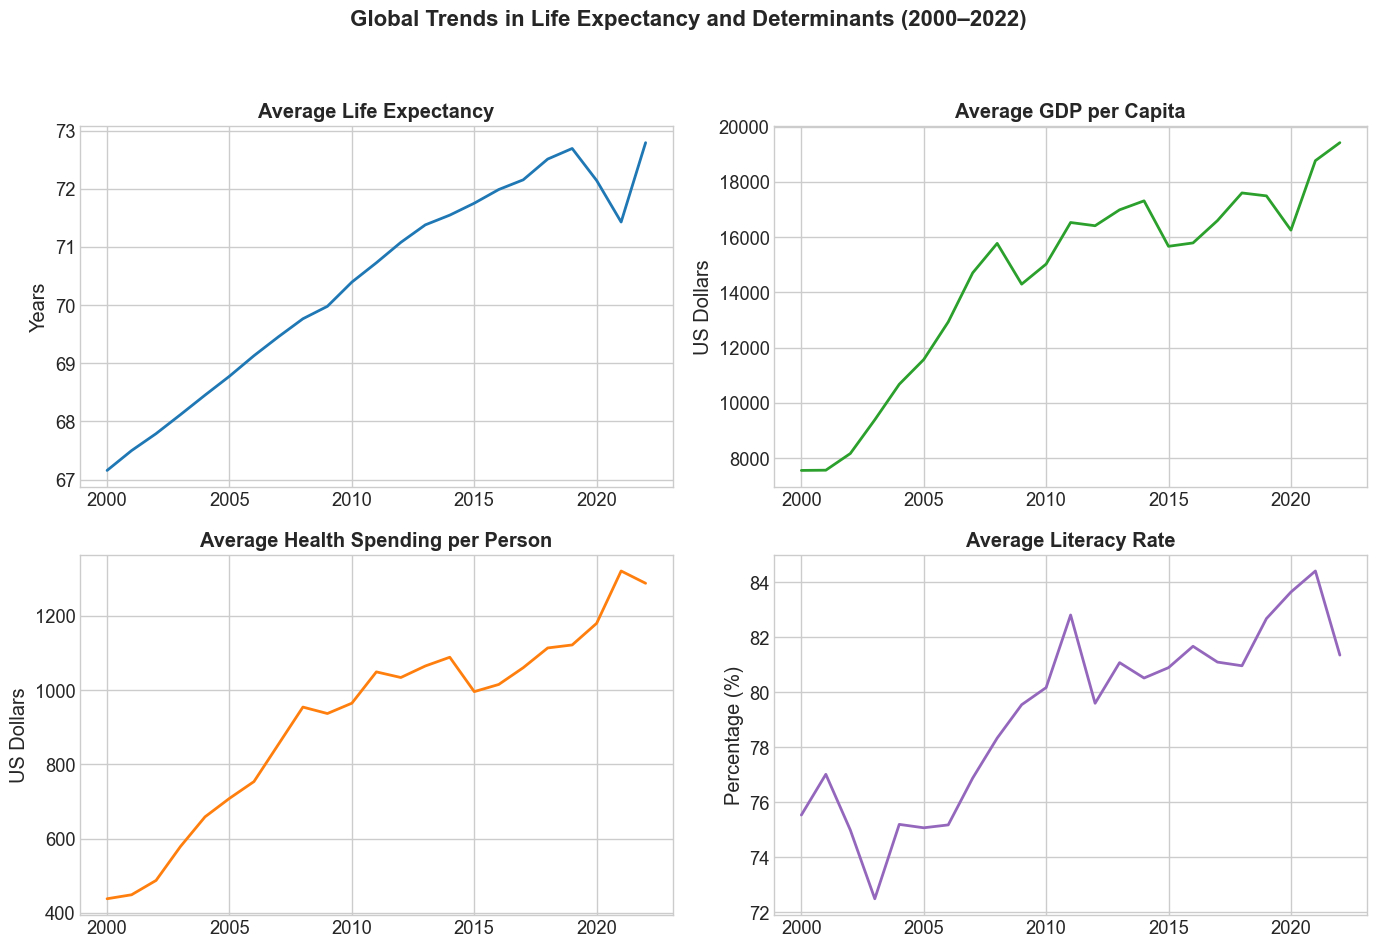

In [8]:
# Compute yearly global averages for each variable
global_means = df.groupby("year").agg({
    "life_expectancy": "mean",
    "gdp_per_capita": "mean",
    "health_spending": "mean",
    "literacy_rate": "mean"
}).reset_index()

global_means.head()
# Time-series with consistent colors
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Global Trends in Life Expectancy and Determinants (2000–2022)", fontsize=16, fontweight='bold')

axes[0,0].plot(global_means['year'], global_means['life_expectancy'], color='#1f77b4', linewidth=2)
axes[0,0].set_title("Average Life Expectancy", fontweight='bold')
axes[0,0].set_ylabel("Years")

axes[0,1].plot(global_means['year'], global_means['gdp_per_capita'], color='#2ca02c', linewidth=2)
axes[0,1].set_title("Average GDP per Capita", fontweight='bold')
axes[0,1].set_ylabel("US Dollars")

axes[1,0].plot(global_means['year'], global_means['health_spending'], color='#ff7f0e', linewidth=2)
axes[1,0].set_title("Average Health Spending per Person", fontweight='bold')
axes[1,0].set_ylabel("US Dollars")

axes[1,1].plot(global_means['year'], global_means['literacy_rate'], color='#9467bd', linewidth=2)
axes[1,1].set_title("Average Literacy Rate", fontweight='bold')
axes[1,1].set_ylabel("Percentage (%)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Time Series Insights

Looking at the global averages of life expectancy, GDP per capita, health spending, literacy, and population between 2000 and 2022 provides several important observations:

1. **Life Expectancy**  
   - Global average life expectancy increased steadily from about **67 years in 2000 to roughly 73 years in 2022**.  
   - This slow but consistent growth reflects improvements in health outcomes worldwide.  

2. **Economic Resources (GDP per capita)**  
   - Global average GDP per capita showed a strong upward trajectory, especially after the early 2000s.  
   - Despite some fluctuations, the overall trend is clearly positive, reflecting rising global income levels.  

3. **Healthcare Spending**  
   - Average per capita health spending rose consistently, suggesting increasing investments in healthcare systems globally.  
   - The upward slope was steady across the whole period, mirroring the improvements in life expectancy.  

4. **Education (Literacy Rate)**  
   - Literacy rates, while already relatively high in 2000, continued to improve gradually over the period.  
   - The global average edged closer to full adult literacy, reinforcing the slow but steady progress in education worldwide.  

5. **Population Growth**  
   - The global population increased year by year, with averages rising continuously from **about 6 billion in 2000 to nearly 8 billion in 2022**.  
   - Unlike other variables, population growth was steady and monotonic, without noticeable dips or slowdowns.  

### Takeaway
The time-series analysis highlights **parallel upward trends** in life expectancy, income, health spending, and literacy rates at the global level. While these figures do not show differences between countries or regions, they clearly illustrate that on average, the world has grown healthier, wealthier, more educated, and more populous over the past two decades.

In [10]:
%pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.8 MB 287 kB/s eta 0:00:01
     |████████████████████████████████| 412 kB 9.5 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import plotly.express as px

latest_year = df.groupby("country").agg({
    "life_expectancy": "last",
    "gdp_per_capita": "last",
    "literacy_rate": "last",
    "health_spending": "last",
    "population": "last"
}).reset_index()

latest_year.columns = ["Country", "Life Expectancy", "GDP per Capita", "Literacy Rate", "Health Spending", "Population"]

#Life Expectancy by Country 
fig1 = px.choropleth(
    latest_year,
    locations="Country",
    locationmode="country names",
    color="Life Expectancy",
    hover_name="Country",
    color_continuous_scale="Viridis",
    title="Life Expectancy by Country (Most Recent Year)",
)
fig1.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig1.show()

# GDP per Capita by Country 
fig2 = px.choropleth(
    latest_year,
    locations="Country",
    locationmode="country names",
    color="GDP per Capita",
    hover_name="Country",
    color_continuous_scale="Blues",
    title="GDP per Capita by Country (Most Recent Year)",
)
fig2.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig2.show()

# Literacy Rate by Country 
fig3 = px.choropleth(
    latest_year,
    locations="Country",
    locationmode="country names",
    color="Literacy Rate",
    hover_name="Country",
    color_continuous_scale="YlGnBu",
    title="Adult Literacy Rate by Country (Most Recent Year)",
)
fig3.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig3.show()

<positron-console-cell-17>:15: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



<positron-console-cell-17>:28: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



<positron-console-cell-17>:41: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [16]:



# keep the latest year per country with required columns present
def latest_per_country_with(df, required_cols):
    tmp = df.dropna(subset=required_cols).sort_values(["country", "year"])
    latest = tmp.groupby("country").tail(1).copy()
    return latest

#Life Expectancy (color) vs GDP per Capita (bubble size)
gdp_latest = latest_per_country_with(df, ["life_expectancy", "gdp_per_capita"])
gdp_latest["gdp_per_capita_clipped"] = gdp_latest["gdp_per_capita"].clip(upper=gdp_latest["gdp_per_capita"].quantile(0.98))

fig1 = px.scatter_geo(
    gdp_latest,
    locations="country",
    locationmode="country names",
    color="life_expectancy",
    size="gdp_per_capita_clipped",
    hover_name="country",
    hover_data={"year": True, "gdp_per_capita": ":,.0f", "life_expectancy": ":.1f"},
    size_max=40,
    projection="natural earth",
    color_continuous_scale="Viridis",
    title="Life Expectancy (Color) vs GDP per Capita (Bubble Size)"
)
fig1.update_layout(margin={"r":0,"t":60,"l":0,"b":0})
fig1.show()

# Life Expectancy (color) vs Health Spending (bubble size)
health_latest = latest_per_country_with(df, ["life_expectancy", "health_spending"])
health_latest["health_spending_clipped"] = health_latest["health_spending"].clip(upper=health_latest["health_spending"].quantile(0.98))

fig2 = px.scatter_geo(
    health_latest,
    locations="country",
    locationmode="country names",
    color="life_expectancy",
    size="health_spending_clipped",
    hover_name="country",
    hover_data={"year": True, "health_spending": ":,.0f", "life_expectancy": ":.1f"},
    size_max=40,
    projection="natural earth",
    color_continuous_scale="YlOrRd",
    title="Life Expectancy (Color) vs Health Spending per Person (Bubble Size)"
)
fig2.update_layout(margin={"r":0,"t":60,"l":0,"b":0})
fig2.show()

# Life Expectancy (color) vs Literacy Rate (bubble size)
lit_latest = latest_per_country_with(df, ["life_expectancy", "literacy_rate"])

fig3 = px.scatter_geo(
    lit_latest,
    locations="country",
    locationmode="country names",
    color="life_expectancy",
    size="literacy_rate",
    hover_name="country",
    hover_data={"year": True, "literacy_rate": ":.1f", "life_expectancy": ":.1f"},
    size_max=35,  
    projection="natural earth",
    color_continuous_scale="Blues",
    title="Life Expectancy (Color) vs Adult Literacy Rate (Bubble Size)"
)
fig3.update_layout(margin={"r":0,"t":60,"l":0,"b":0})
fig3.show()

<positron-console-cell-16>:11: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



<positron-console-cell-16>:31: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



<positron-console-cell-16>:50: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### Global Spatial Analysis: Life Expectancy and Its Determinants

The combination of choropleth and bubble maps offers a detailed geographic perspective on how life expectancy relates to income, health spending, and education across the world. These maps reveal both the absolute distribution of each indicator and the relational patterns between socioeconomic factors and health outcomes.

### 1. Life Expectancy Distribution
The choropleth map of Life Expectancy by Country confirms a clear global divide. The highest life expectancies—typically above 80 years—are concentrated in Western Europe, North America, Oceania, and East Asia. Conversely, much of Sub-Saharan Africa continues to face life expectancies below 60 years. This divide mirrors underlying differences in healthcare access, infrastructure, education, and economic stability. Countries with long-standing investments in public health and social welfare systems consistently achieve higher longevity.

### 2. GDP per Capita and Longevity
The Life Expectancy vs. GDP per Capita bubble map visually reinforces the economic-health relationship. Countries with larger bubbles (high GDP per capita) such as the United States, Canada, Western European nations, Japan, and Australia—are also shaded in lighter yellow tones, indicating higher life expectancy. By contrast, much of Africa and parts of South Asia display smaller bubbles and darker shades, reflecting both low GDP and lower life expectancy. This global pattern suggests that national wealth strongly influences life expectancy, especially at lower income levels, where each incremental gain in GDP translates into significant improvements in living standards, nutrition, sanitation, and healthcare.

### 3. Health Spending and Longevity
The Life Expectancy vs. Health Spending map deepens this picture by highlighting how investment in healthcare correlates with longer lives. Larger bubbles, indicating higher per capita health spending, are again concentrated in North America, Europe, and Oceania. These nations not only spend more but also achieve the world’s highest life expectancies. However, some middle-income countries (e.g., parts of Latin America and Eastern Europe) show moderate spending with comparable life expectancies, implying that efficiency and equity in spending may matter as much as total expenditure. The visual overlap of low spending and short life spans across much of Africa underscores the persistent healthcare financing gap in developing regions.

### 4. Literacy and Longevity
The Life Expectancy vs. Adult Literacy Rate map reveals education’s pivotal role in global health. Countries with high literacy rates (larger, darker blue bubbles) consistently exhibit higher life expectancies. This is particularly evident across Europe, East Asia, and South America, where literacy approaches 100%. Meanwhile, regions with smaller, lighter bubbles—especially in Central and Western Africa—show both lower literacy and shorter life spans.  
The relationship is strikingly linear: as literacy increases, so does life expectancy, which is what we have shown previously through scatterplots. This emphasizes that education extends beyond cognitive skills and that it empowers individuals to make informed health decisions, understand medical information, and access preventive care.


### 6. Global Inequality and Policy Implications
The geographic clustering of health and wealth highlights ongoing global inequities. Even though life expectancy has risen overall since 2000, the pace of improvement is uneven.  
- Economic inequality means many nations still lack the fiscal capacity for universal healthcare or quality education.  
- Educational disparities perpetuate health gaps, especially for women and rural populations.  
- Health investment efficiency varies. Some middle-income nations achieve relatively high life expectancy despite moderate spending, indicating that policy design and system efficiency are critical.


## Discussion

### Key Insights
The results provide strong evidence that **education, income, and healthcare spending are structural drivers of health outcomes**, while population size is not.  

1. **Education as a cornerstone**: The tight relationship between literacy and life expectancy reinforces the importance of education as both a direct determinant (through health literacy, family planning, disease prevention) and an indirect one (via employment and income opportunities).  

2. **Wealth and health are linked — but not indefinitely**: Rising GDP improves nutrition, housing, and healthcare access, but after a point, additional wealth does not translate into longer lives. This supports the concept of a “health plateau” in high-income countries.  

3. **Healthcare spending yields rapid gains in low-resource settings**: Countries with minimal health budgets can make the largest relative improvements. Every additional $100 spent per capita in poorer regions yields large life expectancy benefits.  

4. **Population scale is not destiny**: Despite concerns that high population growth harms health, the data show no direct correlation. Governance, equity, and public investment matter more than size alone.  

### Alignment with Literature
These findings align with the **Social Determinants of Health framework** and with empirical research showing that education and income drive health outcomes globally. They also echo work in development economics (e.g., Preston Curve) showing nonlinear returns of income to health.  


### Limitations
- **Data quality**: Literacy rate data were incomplete for certain countries, reducing sample size.  
- **National averages**: Country-level indicators mask internal inequalities (urban vs rural, gender disparities).  
- **Causality**: This analysis is correlational. Further econometric models such as fixed effects regressions would be needed to establish causal pathways.  


---

## Conclusions

This project set out to examine how life expectancy is related to several key social determinants of health using World Bank data from 2000 to 2022. By combining exploratory time-series analysis, correlation matrices, and scatterplots with regression lines, I was able to assess the influence of income, health spending, education, and population on longevity.

The results show a clear picture:

- **Life expectancy has steadily increased worldwide**, from an average of ~67 years in 2000 to ~73 years in 2022.
- **Education is the strongest driver**: Adult literacy rate exhibited the highest correlation (r ≈ 0.81) with life expectancy, underscoring the direct and indirect role of education in promoting health.
- **Economic resources are essential but show diminishing marginal returns**: GDP per capita (r ≈ 0.59) and health spending per capita (r ≈ 0.58) both improve life expectancy, especially at low levels, but wealthy countries cluster at the top, suggesting that other factors limit gains at high income levels.
- **Population size is not a predictor**: With almost no correlation (r ≈ –0.03), demographic scale by itself does not determine health outcomes. Governance, policy, and distribution of resources are more decisive.
- The **parallel upward trends** across all key indicators suggest that global development has broadly benefited health over the past two decades, though this analysis, being based on averages, cannot capture inequalities within or between countries.

In short, the study confirms the **Social Determinants of Health framework**: longevity is shaped less by medicine alone and more by upstream investments in education, economic growth, and healthcare systems.

---

## Recommendations

Drawing from these findings, several recommendations emerge for policymakers, international organizations, and public health practitioners:

### 1. Invest in Universal Education
Since literacy shows the strongest relationship with life expectancy, expanding access to quality education should be a top priority. Education equips individuals with health knowledge, decision-making skills, and access to better economic opportunities. Investments in **primary and secondary schooling, adult education programs, and closing gender gaps** in education are particularly important.

### 2. Target Healthcare Spending Where It Matters Most
The data suggest that every additional dollar spent on health has the greatest marginal benefit in low- and middle-income countries. Policymakers should focus on expanding **basic primary care, vaccinations, maternal health, and affordable medications** in under-resourced areas. For high-income countries already at the health plateau, improving efficiency and equity of healthcare delivery may matter more than increasing spending.

### 3. Promote Inclusive Economic Growth
Rising GDP per capita is strongly linked to better health, but only when the benefits are shared broadly. Countries should aim for **growth strategies that reduce poverty and inequality**, ensuring that economic expansion translates into improved nutrition, housing, sanitation, and healthcare access for all citizens.

### 4. Do Not Overemphasize Population Control
The negligible correlation between population size and life expectancy suggests that demographic scale alone is not a barrier to health. Instead, policies should focus on **equitable distribution of resources, governance, and health system strengthening**, rather than treating population growth as the primary health challenge.

### 5. Integrate Health Policy with Education and Economic Policy
Because the drivers of life expectancy are cross-sectoral, ministries of health cannot act alone. Governments should create **integrated policies** that connect education, labor markets, economic planning, and healthcare systems. This “whole-of-government” approach ensures that health improvements are embedded into broader social development strategies.

---

## Future Directions

While this project highlights robust correlations, future work should go further:
- **Causal modeling**: Apply regression analysis, fixed-effects models, or instrumental variables to better isolate the causal impact of each determinant.
- **Regional comparisons**: Disaggregate the data by income groups or regions to identify context-specific dynamics (e.g., Sub-Saharan Africa vs. East Asia).
- **Equity-focused indicators**: Incorporate inequality measures (urban–rural gaps, gender disparities) to reveal hidden variation masked by country averages.
- **Policy evaluation**: Link data to specific reforms (such as universal primary education campaigns or healthcare coverage expansions) to assess their measurable impact on health outcomes.

---

### Final Thought
The overarching lesson of this analysis is that **longevity is built on social foundations**. Countries that educate their populations, invest in healthcare, and ensure inclusive prosperity achieve longer, healthier lives for their citizens. While medicine cures disease, it is education, equity, and economic opportunity that sustain health across generations.
